In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [4]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath

import pickle
import tabulate
import wandb
from collections import namedtuple

from meta_learning_data_analysis import *

In [5]:
refresh_cache(locals())

{}

In [6]:
np.set_printoptions(linewidth=160)

[60, 60, 60, 60]

In [ ]:
six_replications_by_dimension_runs = runs_by_dimension(60)
print('Loaded runs')

six_reps_dict = {dimension_name: process_multiple_runs(run_set) 
                 for run_set, dimension_name 
                 in zip(six_replications_by_dimension_runs, DIMENSION_NAMES)}

combined_six_replications_runs = [run 
                                  for dimension_runs in six_replications_by_dimension_runs 
                                  for run in dimension_runs]

six_reps_dict[COMBINED] = process_multiple_runs(combined_six_replications_runs) 
six_replications_analyses = ConditionAnalysesSet(**six_reps_dict)


Loaded runs


/Users/guydavidson/projects/deep-learning-projects/notebooks/meta_learning_data_analysis.py:210: RuntimeWarning: divide by zero encountered in log
  log_examples.append(np.log(examples_to_criterion))


## Plot the results

In [308]:
def accuracy_by_times_trained_on(ax, results, log_x=False, log_y=False, shade_error=False):
    num_points = results.mean.shape[0]
    nonzero_rows, nonzero_cols = np.nonzero(results.mean)
    means = [results.mean[r, c] for (r, c) in zip(nonzero_rows, nonzero_cols)]
    
    
    ax.scatter(nonzero_rows + 1, means, 
                                 color=[colors(x / num_points) for x 
                                        in abs(nonzero_cols - nonzero_rows)])
    
    # TODO: verify this does the right thing for the accuracies. It might not
    for task in range(num_points):
        x_values = np.arange(1, num_points - task + 1)
        y_means = np.diag(results.mean, task)
        y_stds = np.diag(results.std, task) / (sem_n ** 0.5)
        
        ax.plot(x_values, y_means, color=colors(task / 10))
        if shade_error:
            ax.fill_between(x_values, y_means - y_stds, y_means + y_stds,
                            color=colors(task / 10), alpha=0.25)
        
    if ylim is not None:
        ax.set_ylim(ylim)

    if log_x:
        ax.set_xscale("log", nonposx='clip')
    
    if log_y:
#         ax.set_yscale("log", nonposy='clip')
        y_min, y_max = ax.get_ylim()
        y_min_pow_10 = np.ceil(y_min * np.log10(np.e))
        y_max_pow_10 = np.ceil(y_max * np.log10(np.e))
        
        y_powers_10 = np.arange(y_min_pow_10, y_max_pow_10)
        y_ticks = np.log(10) * y_powers_10
        y_tick_labels = [f'$10^{{ {int(y_tick)} }}$' for y_tick in y_powers_10]
        
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_tick_labels)
        
#     ax.set_ylabel(f'{log_y and "log(" or ""}{results.name}{log_y and ")" or ""}')
    ax.set_ylabel(f'{results.name}')
    ax.set_xlabel(f'{log_x and "log(" or ""}Number of times trained on{log_x and ")" or ""}')
    ax.set_title(f'{results.name} vs. times trained on')
    
    
def accuracy_by_num_tasks_trained(ax, results, ylim=None, log_x=False, log_y=False, shade_error=False):
    num_points = results.mean.shape[0]
    nonzero_rows, nonzero_cols = np.nonzero(results.mean)
    means = [results.mean[r, c] for (r, c) in zip(nonzero_rows, nonzero_cols)]
    
#     ax.scatter(nonzero_cols + 1, results.mean, 
#                                  color=[colors(x / 10) for x in abs(nonzero_cols - nonzero_rows)])
    for task in range(num_points):
        x_values = np.arange(task + 1, num_points + 1)
#         y_means = np.diag(results.mean, task)
#         y_stds = np.diag(results.std, task) / (sem_n ** 0.5)
        y_means = results.mean[task, task:]
        y_stds = results.std[task, task:] / (sem_n ** 0.5)
        ax.scatter(x_values, y_means, color=colors(task / 10))
        ax.plot(x_values, y_means, color=colors(task / 10))
        if shade_error:
            ax.fill_between(x_values, y_means - y_stds, y_means + y_stds,
                            color=colors(task / 10), alpha=0.25)
    
    if ylim is not None:
        ax.set_ylim(ylim)
    
    if log_x:
        ax.set_xscale("log", nonposx='clip')
        
    if log_y:
#         ax.set_yscale("log", nonposy='clip')
        y_min, y_max = ax.get_ylim()
        y_min_pow_10 = np.ceil(y_min * np.log10(np.e))
        y_max_pow_10 = np.ceil(y_max * np.log10(np.e))
        
        y_powers_10 = np.arange(y_min_pow_10, y_max_pow_10)
        y_ticks = np.log(10) * y_powers_10
        y_tick_labels = [f'$10^{{ {int(y_tick)} }}$' for y_tick in y_powers_10]
        
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_tick_labels)
        
    ax.set_xlabel(f'{log_x and "log(" or ""}Number of tasks trained on{log_x and ")" or ""}')
    ax.set_ylabel(f'{results.name}')
    ax.set_title(f'{results.name} vs. tasks trained on')


def plot_processed_results(results, title, ylim=None, log_x=False, log_y=None,
                           sem_n=1, shade_error=False, plot_bottom=False, colormap='tab10'):
    figure = plt.figure(figsize=(12, 6 + 6 * plot_bottom))
    NROWS = 1 + plot_bottom
    NCOLS = 2
    
    figure.suptitle(title)
    colors = plt.get_cmap(colormap)
    
    if hasattr(log_x, '__len__'):
        if len(log_x) == 1:
            log_x_num_times_trained = log_x[0]
            log_x_num_current_tasks = log_x[0]
        else:
            log_x_num_times_trained = log_x[0]
            log_x_num_current_tasks = log_x[1]
            
    else:
        log_x_num_times_trained = log_x
        log_x_num_current_tasks = log_x
        
    if log_y is None:
        log_y = 'log' in results.name
        
    num_times_trained_ax = plt.subplot(NROWS, NCOLS, 1)
    accuracy_by_times_trained_on(num_times_trained_ax, results, ylim, log_x_num_times_trained, log_y, shade_error)
    
    num_current_tasks_ax = plt.subplot(NROWS, NCOLS, 2)
    accuracy_by_num_tasks_trained(num_current_tasks_ax, results, ylim, log_x_num_current_tasks, log_y, shade_error)
            
#     if plot_bottom:
#         # Accuracy as a function of both
#         both_ax = plt.subplot(NROWS, NCOLS, 3, projection='3d')
#         both_ax.scatter(nonzero_rows, nonzero_cols, values)

#         both_ax.set_zscale("log")
#         both_ax.set_xlabel('Number of times trained on')
#         both_ax.set_ylabel('Number of tasks trained on')
#         both_ax.set_zlabel('log(examples to criterion)')
#         both_ax.set_title('# examples to criterion vs. both')

#         # Accuracy as a function of both in a heatmap
#         heatmap_ax = plt.subplot(NROWS, NCOLS, 4)
#         heatmap_ax.imshow(np.log(examples_to_criterion + 1), cmap='YlOrRd')
#         for i in range(10):
#             for j in range(i, 10):
#                 text = heatmap_ax.text(j, i, examples_to_criterion[i, j],
#                                ha="center", va="center", color="w", fontsize=8)


#         heatmap_ax.set_xlabel('Number of times trained on')
#         heatmap_ax.set_ylabel('Number of tasks trained on')
#         heatmap_ax.set_title('Heatmap of # examples to criterion')
    
    plt.show()



## Plot the number of examples by dimension

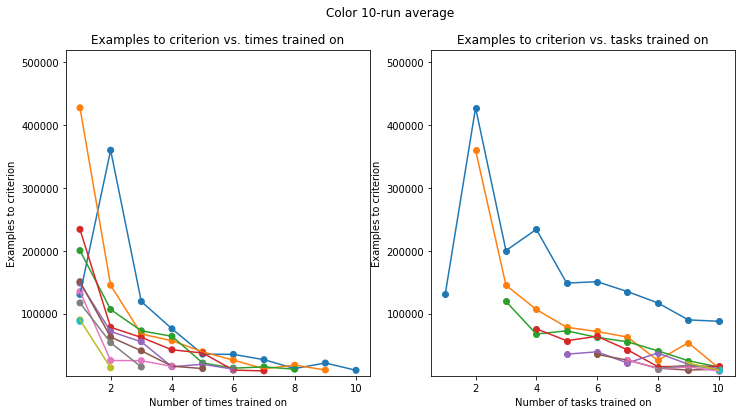

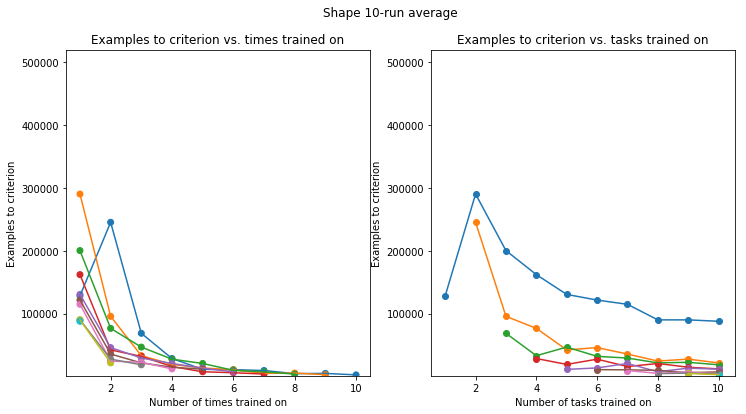

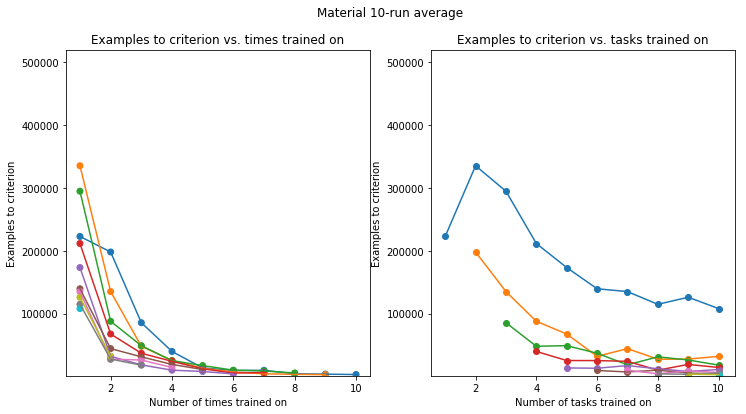

In [346]:
ylim = (1000, 520000)

plot_processed_results(first_replication_analyses.color.examples, 'Color 10-run average', ylim)
plot_processed_results(first_replication_analyses.shape.examples, 'Shape 10-run average', ylim)
plot_processed_results(first_replication_analyses.texture.examples, 'Material 10-run average', ylim)

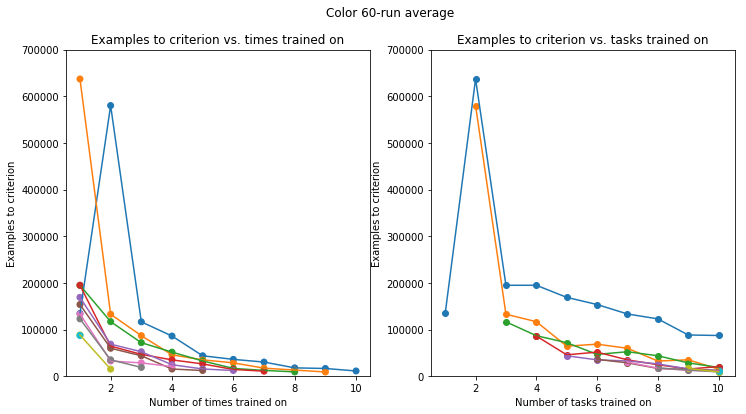

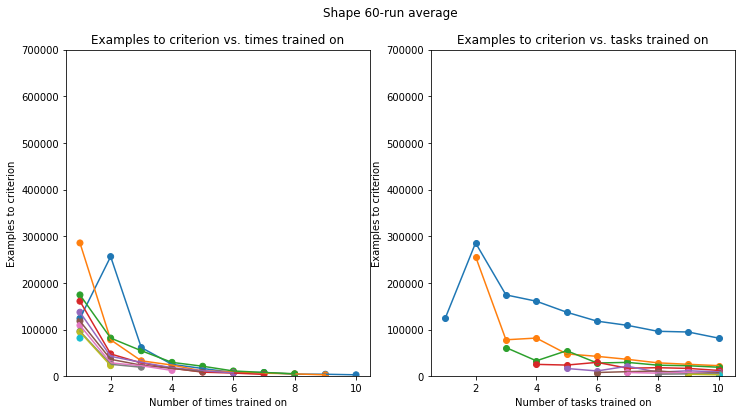

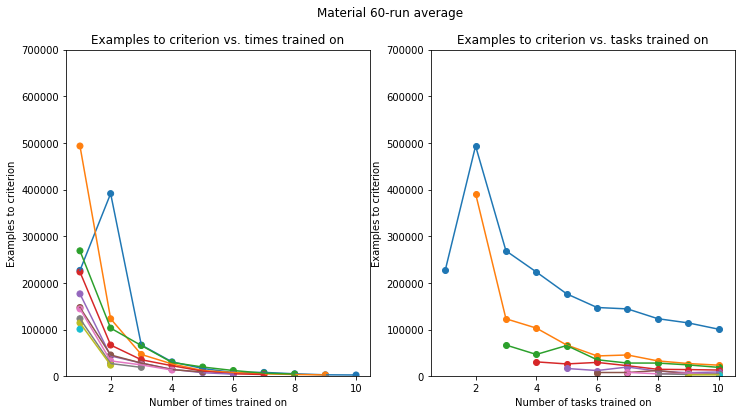

In [348]:
ylim = (1000, 700000)

plot_processed_results(six_replications_analyses.color.examples, 'Color 60-run average', ylim)
plot_processed_results(six_replications_analyses.shape.examples, 'Shape 60-run average', ylim)
plot_processed_results(six_replications_analyses.texture.examples, 'Material 60-run average', ylim)

## Plot the log of the number of examples to criterion, in each dimension, with error bars

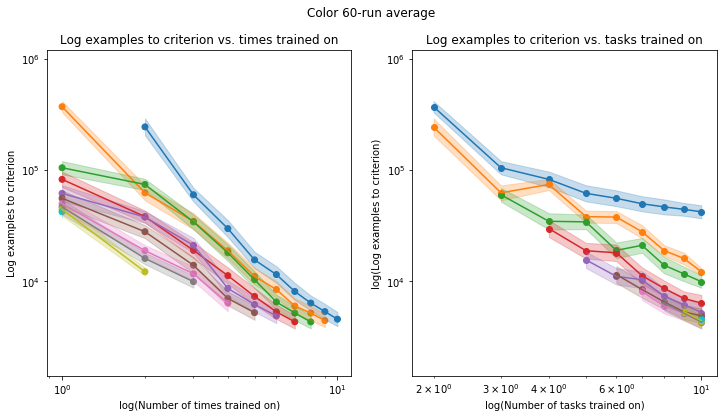

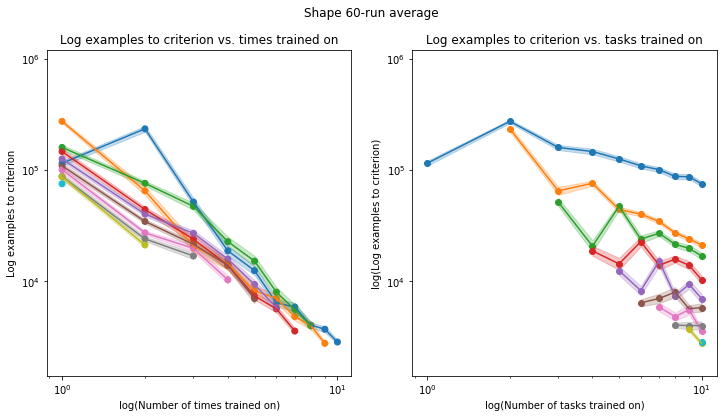

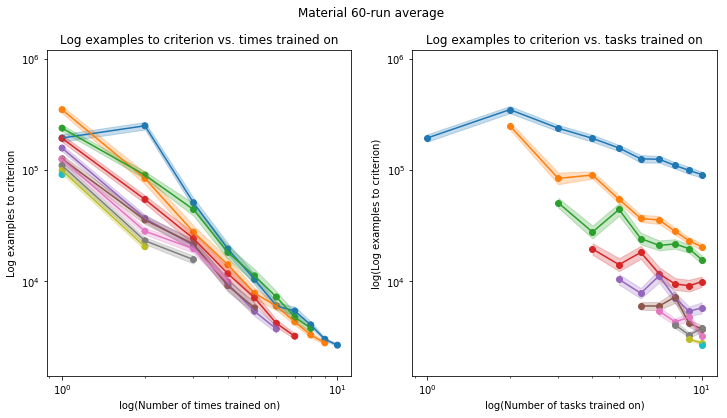

In [349]:
ylim = (7.25, 14)

plot_processed_results(six_replications_analyses.color.log_examples, 'Color 60-run average', 
                       ylim, log_x=True, log_y=True, sem_n=60, shade_error=True)
plot_processed_results(six_replications_analyses.shape.log_examples, 'Shape 60-run average', 
                       ylim, log_x=True, log_y=True, sem_n=60, shade_error=True)
plot_processed_results(six_replications_analyses.texture.log_examples, 'Material 60-run average', 
                       ylim, log_x=True, log_y=True, sem_n=60, shade_error=True)

## Plot the combined results over all 180 runs

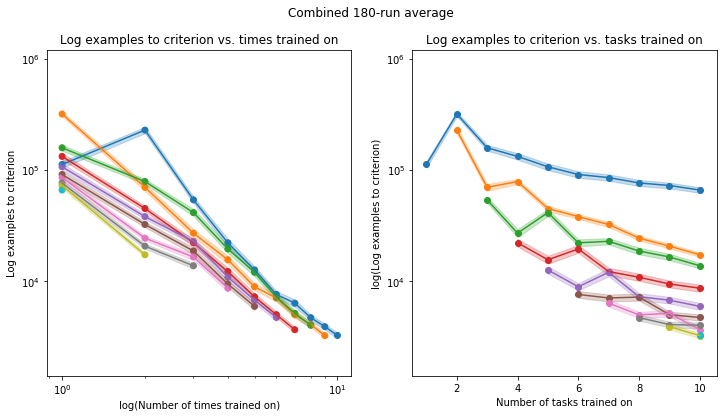

In [350]:
plot_processed_results(six_replications_analyses.combined.log_examples, 'Combined 180-run average', 
                       ylim, log_x=(True, False), log_y=True, sem_n=180, shade_error=True)

## Plot the absolute accuracy after introducing a new task

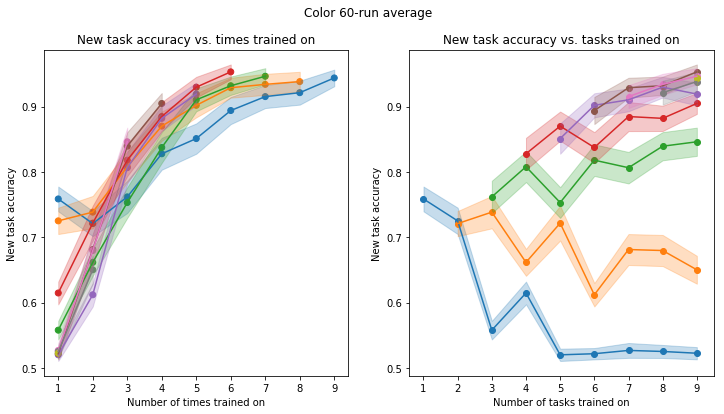

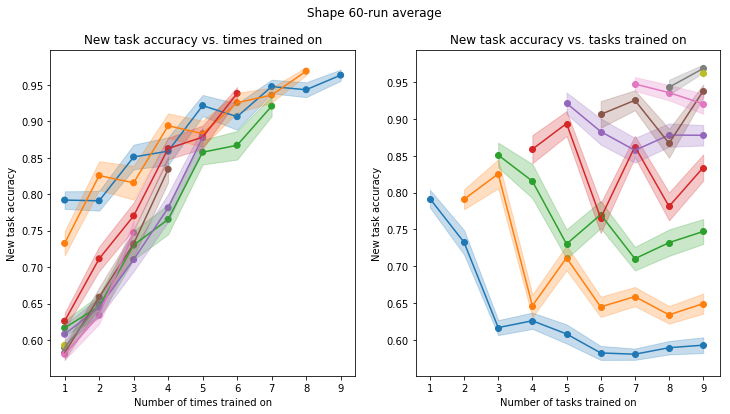

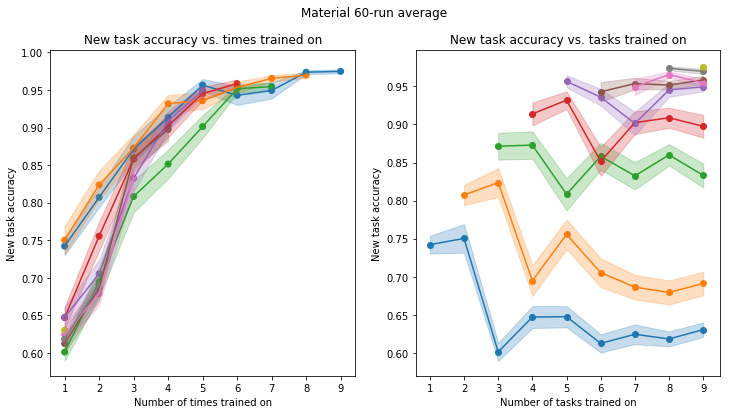

In [351]:
ylim = None

plot_processed_results(six_replications_analyses.color.accuracies, 'Color 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)
plot_processed_results(six_replications_analyses.shape.accuracies, 'Shape 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)
plot_processed_results(six_replications_analyses.texture.accuracies, 'Material 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)

## Plot the accuracy drop after introducing a new task

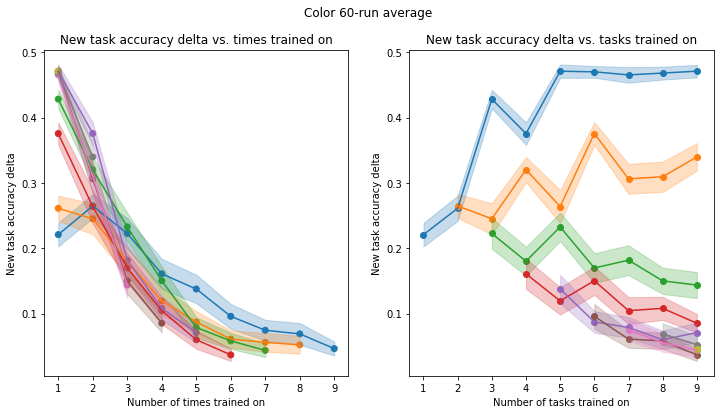

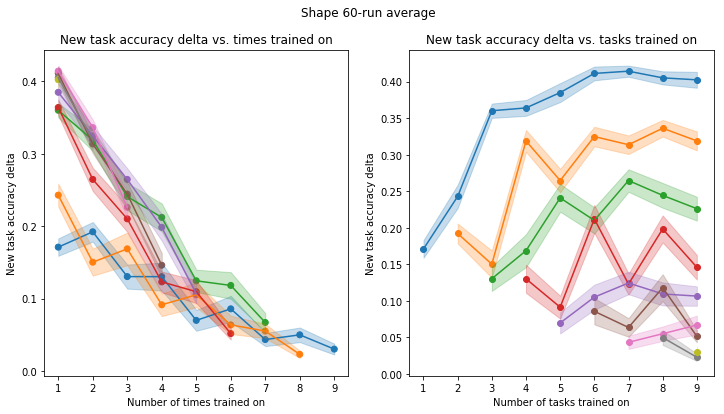

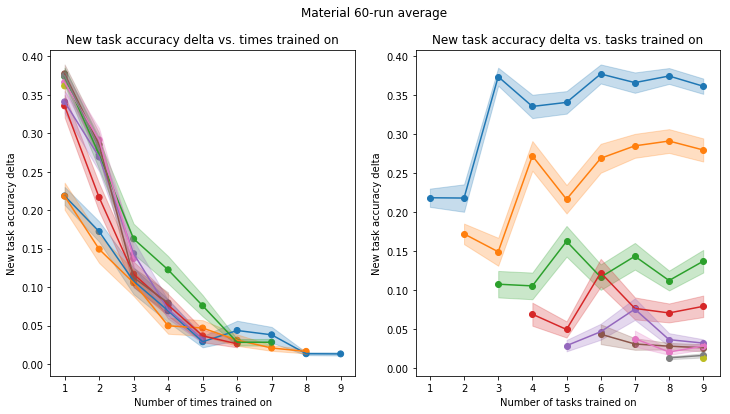

In [352]:
ylim = None

plot_processed_results(six_replications_analyses.color.accuracy_drops, 'Color 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)
plot_processed_results(six_replications_analyses.shape.accuracy_drops, 'Shape 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)
plot_processed_results(six_replications_analyses.texture.accuracy_drops, 'Material 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)

# Scratch work

## Looking for outlines and analyzing the skewness of these distributions

In [160]:
from scipy.stats import skew, skewtest

In [165]:
output, examples = process_multiple_runs(six_replications_by_dimension_runs[1], debug=True)

In [166]:
ex = np.array(examples)

(array([16.,  0., 19.,  0.,  8.,  0.,  8.,  0.,  3.,  0.,  0.,  0.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  2.]),
 array([ 2500.,  3750.,  5000.,  6250.,  7500.,  8750., 10000., 11250., 12500., 13750., 15000., 16250., 17500., 18750., 20000., 21250., 22500., 23750., 25000.,
        26250., 27500.]),
 <a list of 20 Patch objects>)

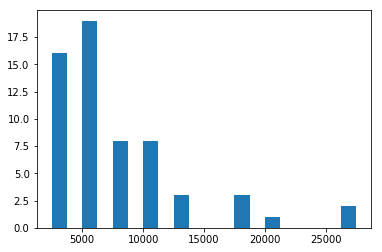

In [167]:
plt.hist(ex[:,5,9], bins=20)

In [168]:
pretty_print_results(skew(ex),  floatfmt=".3f")

╒═══════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═══════╕
│   ### │       1 │       2 │       3 │       4 │       5 │       6 │       7 │       8 │       9 │    10 │
╞═══════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═══════╡
│     1 │   0.302 │   2.829 │   1.093 │   0.096 │   0.644 │   0.691 │   0.630 │   0.923 │   0.944 │ 0.696 │
├───────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────┤
│     2 │ nan     │   2.132 │   0.702 │   0.479 │   0.269 │   0.982 │   0.603 │   1.018 │   0.689 │ 1.133 │
├───────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────┤
│     3 │ nan     │ nan     │   1.243 │   1.922 │   1.199 │   0.546 │   0.332 │   1.127 │   1.307 │ 1.237 │
├───────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────┤
│     4 │ nan     │ nan     

In [169]:
res = skewtest(ex)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/guydavidson/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/guydavidson/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [170]:
res.pvalue < 0.001

/Users/guydavidson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


array([[False,  True, False, False, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False, False, False,  True],
       [False, False,  True,  True,  True, False, False,  True,  True,  True],
       [False, False, False,  True,  True,  True, False, False, False, False],
       [False, False, False, False,  True,  True,  True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True, False],
       [False, False, False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False, False, False,  True]])

## Analyzing the average number of example for each actual query/task

In [207]:
query_difficulty = sum([r[1] for r in six_replications_by_dimension])
query_names = ['blue', 'brown', 'cyan', 'gray', 'green', 'orange', 'pink',
       'purple', 'red', 'yellow', 'cone', 'cube', 'cylinder',
       'dodecahedron', 'ellipsoid', 'octahedron', 'pyramid', 'rectangle',
       'sphere', 'torus', 'chain_mail', 'marble', 'maze', 'metal',
       'metal_weave', 'polka', 'rubber', 'rug', 'tiles', 'wood_plank']
dimension_names = ['color', 'shape', 'texture']

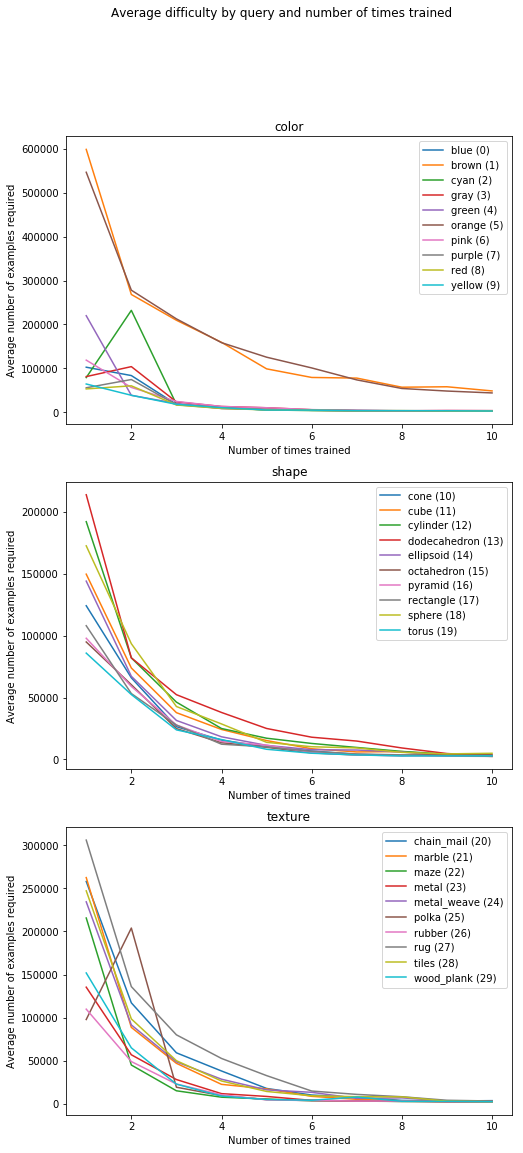

In [269]:
plt.figure(figsize=(8, 18))

plt.suptitle('Average difficulty by query and number of times trained')

for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    x_values = range(1, 11)
    
    for query_id in range(i * 10, (i + 1) * 10):
        ax.plot(x_values, query_difficulty[query_id,:], label=f'{query_names[query_id]} ({query_id})')
    
    ax.set_title(dimension_names[i])
    ax.set_xlabel('Number of times trained')
    ax.set_ylabel('Average number of examples required')
    ax.legend(loc='best')
    

plt.show()

In [320]:
a = (1, 2, 3)
b = (4, 5, 6)

{c: d for (c, d) in zip(a, b)}

{1: 4, 2: 5, 3: 6}